In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import Ridge
import sklearn.gaussian_process.kernels as kernels
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay

np.set_printoptions(linewidth=150, edgeitems=5)
result_list = []

In [11]:
train = pd.read_csv("train.csv", index_col='ID')
test = pd.read_csv("test.csv", index_col="ID")
sub = pd.read_csv("sample_submission.csv")

target = 'y'
original_features = list(test.columns)

print(f"Length of train: {len(train)}")
print(f"Length of test:  {len(test)}")

traindup = train[test.columns].duplicated().sum()
print(f"Duplicates in train: {traindup:4}")
print(f"Duplicates in test:  {test.duplicated().sum():4}")
print(f"Duplicates in train and test together: {pd.concat([train, test], axis=0)[test.columns].duplicated().sum()}")
print()

Length of train: 40118
Length of test:  4986
Duplicates in train:    0
Duplicates in test:     0
Duplicates in train and test together: 0



In [12]:
# def analyze(train, test, col, ax):
#     """Plot a histogram for column col into axes ax"""
#     bins = 40
#     column = train[col]
#     if col in test.columns:
#         both = np.hstack([column.values, test[col].values])
#     else:
#         both = column
#     uni = np.unique(column)
#     unival = len(uni)
#     if unival < bins:
#         vc_tr = column.value_counts().sort_index() / len(train)
#         if col in test.columns:
#             vc_te = test[col].value_counts().sort_index() / len(test)
#             ax.bar(vc_tr.index, vc_tr, width=6, label='train', alpha=0.5)
#             ax.bar(vc_te.index, vc_te, width=6, label='test', alpha=0.5)
#         else:
#             ax.bar(vc_tr.index, vc_tr, label='train', alpha=0.5)
#         if unival <= 12:
#             ax.set_xticks(vc_tr.index)
#         else:
#             ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
#         ax.set_xlabel(col + (' (target)' if col == target else ''))
#         ax.set_ylabel('density')
#         ax.legend()
#     else:
#         hist_bins = np.linspace(both.min(), both.max(), bins+1)
#         ax.hist(column, bins=hist_bins, density=True, label='train', alpha=0.5)
#         if col in test.columns:
#             ax.hist(test[col], bins=hist_bins, density=True, label='test', alpha=0.5)
#         ax.set_xlabel(col + (' (target)' if col == target else ''))
#         ax.set_ylabel('density')
#         ax.legend()
    
# _, axs = plt.subplots(4, 3, figsize=(12, 10))
# axs = axs.ravel()
# for col, ax in zip(train.columns, axs):
#     analyze(train, test, col, ax)
# plt.tight_layout(h_pad=0.5, w_pad=0.5)
# plt.show()

In [13]:
# corr = train.corr()
# plt.figure(figsize=(10,10))
# sns.heatmap(corr, linewidth=0.1, fmt='.1f', 
#             annot=True, annot_kws={'size': 8}, 
#             cmap='PiYG', center=0)
# plt.show()

In [14]:
def score_model(model, features_used, label=None):
    """Cross-validate a model with feature selection"""
    score_list = []
    oof = np.zeros_like(train[target])
    kf = KFold()
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
        X_tr = train.iloc[idx_tr][features_used]
        X_va = train.iloc[idx_va][features_used]
        y_tr = train.iloc[idx_tr][target]
        y_va = train.iloc[idx_va][target]
        
        
        model.fit(X_tr, y_tr)
        trmse = mean_squared_error(y_tr, model.predict(X_tr), squared=False)
        y_va_pred = model.predict(X_va)
        rmse = mean_squared_error(y_va, y_va_pred, squared=False)
        if type(model) == Pipeline and type(model.steps[-1][1]) == GaussianProcessRegressor:
            print('Kernel:', model.steps[-1][1].kernel_)
        print(f"Fold {fold}: trmse = {trmse:.3f}   rmse = {rmse:.3f}")
        oof[idx_va] = y_va_pred
        score_list.append(rmse)

    rmse = sum(score_list) / len(score_list)
    print(f"Average rmse: {rmse:.3f}")
    if label is not None:
        global result_list
        result_list.append((label, rmse, oof))

score_model(model=make_pipeline(StandardScaler(), Ridge(70)),
            features_used=original_features)

Fold 0: trmse = 1.684   rmse = 1.618
Fold 1: trmse = 1.682   rmse = 1.628
Fold 2: trmse = 1.690   rmse = 1.594
Fold 3: trmse = 1.605   rmse = 1.914
Fold 4: trmse = 1.693   rmse = 1.582
Average rmse: 1.667


In [15]:
for df in [train, test]:
    df['clip_x_8'] = df.x_8.clip(None, 0.675)
    
score_model(model=make_pipeline(StandardScaler(), Ridge(70)),
            features_used=original_features)

for df in [train, test]:
    df['clip_x_10'] = df.x_10.clip(None, 0.07)
    
score_model(model=make_pipeline(StandardScaler(), Ridge(30)),
            features_used=test.columns)

Fold 0: trmse = 1.684   rmse = 1.618
Fold 1: trmse = 1.682   rmse = 1.628
Fold 2: trmse = 1.690   rmse = 1.594
Fold 3: trmse = 1.605   rmse = 1.914
Fold 4: trmse = 1.693   rmse = 1.582
Average rmse: 1.667
Fold 0: trmse = 1.682   rmse = 1.614
Fold 1: trmse = 1.679   rmse = 1.626
Fold 2: trmse = 1.688   rmse = 1.590
Fold 3: trmse = 1.602   rmse = 1.912
Fold 4: trmse = 1.690   rmse = 1.580
Average rmse: 1.665


In [16]:
ridge_features = ['x_1', 'x_2', 'clip_x_8', 'x_9', 'clip_x_10']
score_model(model=make_pipeline(StandardScaler(), Ridge(30)),
            features_used=ridge_features,
            label='Ridge')

Fold 0: trmse = 1.688   rmse = 1.617
Fold 1: trmse = 1.684   rmse = 1.631
Fold 2: trmse = 1.692   rmse = 1.598
Fold 3: trmse = 1.607   rmse = 1.917
Fold 4: trmse = 1.695   rmse = 1.585
Average rmse: 1.669


In [17]:
gp_features = ['x_2', 'x_8', 'x_10']

kernel = kernels.RBF(length_scale=[1] * (len(gp_features)-1) + [0.07], length_scale_bounds=(0.01, 10)) + kernels.WhiteKernel(0.55)
score_model(model=make_pipeline(StandardScaler(), GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=1)),
            features_used=gp_features,
            label='Gaussian Process') 

In [18]:
gbr_params = {'n_estimators': 550,
              'max_depth': 4,
              'learning_rate': 0.01,
              'min_samples_leaf': 30 ,
              'max_features': 3}
# score_model(model=GradientBoostingRegressor(**gbr_params, random_state=1),
#             features_used=original_features,
#             label='GradientBoostingRegressor')

In [19]:
ensemble_model = VotingRegressor(
    [('gb', make_pipeline(ColumnTransformer([('pt', 'passthrough', original_features)]),
                          GradientBoostingRegressor(**gbr_params, random_state=1))),
     ('rf', make_pipeline(ColumnTransformer([('pt', 'passthrough', original_features)]),
                          RandomForestRegressor(n_estimators=300, min_samples_leaf=30,
                                                random_state=1))),
     ('ridge', make_pipeline(ColumnTransformer([('pt', 'passthrough', ridge_features)]),
                             StandardScaler(),
                             Ridge(30))),
    ],
    weights=[0.4, 0.3, 0.3])
score_model(model=ensemble_model,
            features_used=test.columns,
            label='GradientBoostingRegressor + RF + Ridge')

Fold 0: trmse = 1.628   rmse = 1.609
Fold 1: trmse = 1.625   rmse = 1.624
Fold 2: trmse = 1.633   rmse = 1.591
Fold 3: trmse = 1.546   rmse = 1.913
Fold 4: trmse = 1.634   rmse = 1.579
Average rmse: 1.663


,label,rmse
1,GradientBoostingRegressor + RF + Ridge,1.663
0,Ridge,1.669


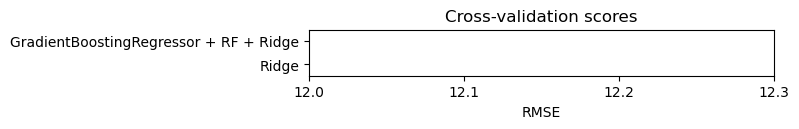

In [23]:
result_df = pd.DataFrame(result_list, columns=['label', 'rmse', 'oof'])
result_df.drop_duplicates(subset='label', keep='last', inplace=True)
result_df.sort_values('rmse', inplace=True)
with pd.option_context("display.precision", 3):
    display(result_df[['label', 'rmse']])
plt.figure(figsize=(6, len(result_df) * 0.3))
plt.title('Cross-validation scores')
plt.barh(np.arange(len(result_df)), result_df.rmse, color='lightgreen')
plt.gca().invert_yaxis()
plt.yticks(np.arange(len(result_df)), result_df.label)
plt.xticks(np.linspace(12, 12.3, 4))
plt.xlabel('RMSE')
plt.xlim(12, 12.3)
# plt.savefig('cv-scores.png', bbox_inches='tight')
plt.show()

In [24]:
ensemble_model.fit(train[test.columns], train[target])
y_pred = ensemble_model.predict(test[test.columns])
pd.Series(y_pred, index=test.index, name=target).to_csv(f"submission.csv")
y_pred.round(1)

array([83.6, 82.2, 90.5, 91.2, 82.1, ..., 83.5, 91.3, 82.8, 82.9, 82.2])